In [1]:
!python --version

Python 3.8.8


In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

import PIL
from PIL import Image,UnidentifiedImageError,ImageFile

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
import cv2 as cv

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,Activation
from keras.models import save_model,load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model

print(tf.__version__)

2.4.1


In [3]:
Image.MAX_IMAGE_PIXELS = 933120000
IMG_SIZE = (50,50)
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# DATASET PATHS
DATASET_DIR = Path('NEW_DATASET_10')

In [5]:
# Setting Up Directories

# TRAIN DATA PATH
TRAIN_CSV_PATH = os.path.join(DATASET_DIR,'TRAIN','multimodal_train.csv')
TRAIN_IMG_PATH = os.path.join(DATASET_DIR,'TRAIN','IMAGES')

# TEST DATA PATH
TEST_CSV_PATH = os.path.join(DATASET_DIR,'TEST','multimodal_test.csv')
TEST_IMG_PATH = os.path.join(DATASET_DIR,'TEST','IMAGES')

# VALIDATE DATA PATH
VALIDATE_CSV_PATH = os.path.join(DATASET_DIR,'VALIDATE','multimodal_validate.csv')
VALIDATE_IMG_PATH = os.path.join(DATASET_DIR,'VALIDATE','IMAGES')

# PRE_PROCESSED DATA PATHS
PRE_PROCESSED_TRAIN_DATA_PATH = os.path.join(DATASET_DIR,'PROCESSED_DATA','train_data.npz')
PRE_PROCESSED_TEST_DATA_PATH = os.path.join(DATASET_DIR,'PROCESSED_DATA','test_data.npz')
PRE_PROCESSED_VALIDATE_DATA_PATH = os.path.join(DATASET_DIR,'PROCESSED_DATA','validate_data.npz')

# Model Outputs
MODEL_OUTPUT_DIR = Path('Model_Outputs')

In [6]:
train_df = pd.read_csv(TRAIN_CSV_PATH,low_memory=False)
validate_df = pd.read_csv(VALIDATE_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)

In [7]:
def _isImgCorrupted(img):
    try:
        im = Image.open(img)
        im.verify()
        return False
 
    except FileNotFoundError:
        return True
    
    except SyntaxError:
        return True
    
    except PIL.UnidentifiedImageError:
        return True

In [8]:
def check_remove_corrupted_images(df,IMG_PATH):
    corruptCount = 0
    temp_df = df[['id','2_way_label']]
    for i,row in temp_df.iterrows():
        img,_ = row.tolist()
        impath = os.path.join(IMG_PATH,f'{img}.jpg')
        try:
            if _isImgCorrupted(impath):
                print(i,img)
                df = df.drop(i)
                corruptCount += 1
        
        except Exception as e:
            print(f'Error in {img} : {e}')
            # sys.exit(0)
    print(f'Removed {corruptCount} corrupted images.')
    return df

In [9]:
train_df = shuffle(train_df)
test_df = shuffle(test_df)
validate_df = shuffle(validate_df)

In [10]:
train_df = check_remove_corrupted_images(train_df,TRAIN_IMG_PATH)
test_df = check_remove_corrupted_images(test_df,TEST_IMG_PATH)
validate_df = check_remove_corrupted_images(validate_df,VALIDATE_IMG_PATH)

52854 chmlqm2
36180 c9t9efu
49288 csb9lwl
55192 ddj7mjf
39432 f3snfue
56150 dhig0jf
48986 ca9ko4d
43659 d0t4oap
35840 cqh3dwe
32504 c82xgjo
48146 euf4y6i
49619 c4uolqt
33348 d0z4kl2
48604 c89m77i
39277 dsqptd5
37428 c8frys7
36300 corzta4
52462 cfgh9p6
39597 cmcpahb
34859 csjp1ca
51152 cdekcw4
39220 cn6693m
43944 ds6txmd
56321 e5a0irs
42369 cea9g9y
36308 cm2petz
37369 cafzidr
37920 dcp93kl
45643 c5qkhy6
37981 c8uqsjg
31102 cbyr0zz
30400 f3704pg
36063 f2zd5yw
36040 dn406w7
56044 c76o894
33653 drslqwx
Removed 36 corrupted images.
4711 c7nbduy
4646 dhmh8hc
4123 cac53b8
Removed 3 corrupted images.
5084 ctlphvf
3808 c89rc9d
3018 cmk2pxb
Removed 3 corrupted images.


In [11]:
def append_ext(fn):
    return fn+".jpg"
train_df["id"]=train_df["id"].apply(append_ext)
validate_df["id"]=validate_df["id"].apply(append_ext)
test_df['id']=test_df['id'].apply(append_ext)

In [12]:
train_df[['id','2_way_label']].head()

,id,2_way_label
32322,6pgvwk.jpg,0
30606,c86fi95.jpg,0
41678,cd7l698.jpg,0
54475,7alece.jpg,0
26134,c9s8oe.jpg,1


In [13]:
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.3)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_IMG_PATH,
    x_col='id',
    y_col='2_way_label',
    class_mode='raw',
    target_size=IMG_SIZE,
    batch_size=32
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=validate_df,
    directory=VALIDATE_IMG_PATH,
    x_col='id',
    y_col='2_way_label',
    class_mode='raw',
    target_size=IMG_SIZE,
    batch_size=32
)

Found 56364 validated image filenames.
Found 5931 validated image filenames.


In [2]:
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import BatchNormalization,Input
from keras import layers
from keras.utils import plot_model

In [15]:
# inputs = layers.Input(shape=(50,50,3))

# a_conv_1 = layers.Conv2D(32,(2,2))(inputs)
# a_maxpool_1 = layers.MaxPooling2D((2,2))(a_conv_1)

# b = Dense(128)(inputs)
# b1 = Dense(1)(b)

# m = Model(inputs=inputs, outputs=[a_maxpool_1,b1])
# plot_model(m,show_shapes=True)

In [3]:
im_inputs = layers.Input(shape=(50,50,3))

# Visual Latent
vl = layers.Conv2D(32,kernel_size=(2,2))(im_inputs)
vl = layers.Activation(activation='relu')(vl)

vl = layers.Dropout(0.8)(vl)
vl = layers.MaxPooling2D(pool_size=(2,2))(vl)
vl = layers.Conv2D(32,kernel_size=(2,2))(vl)
vl = layers.Activation(activation='relu')(vl)

vl = layers.Dropout(0.8)(vl)
vl = layers.MaxPooling2D(pool_size=(2,2))(vl)
vl = layers.Conv2D(32,kernel_size=(2,2))(vl)
vl = layers.Activation(activation='relu')(vl)

vl = layers.Dropout(0.8)(vl)
vl = layers.MaxPooling2D(pool_size=(2,2))(vl)

vl = layers.Flatten()(vl)
vl = layers.Dense(128)(vl)
vl = layers.BatchNormalization()(vl)
vl_op = layers.Activation(activation='relu')(vl)


# Visual Explicit
ve = layers.Dense(128)(im_inputs)
ve = layers.Flatten()(ve)
ve = layers.BatchNormalization()(ve)
ve_op = layers.Activation(activation='relu')(ve)

im_merge = layers.concatenate([vl_op,ve_op])


img_model_actv_1 = layers.Activation(activation='relu')(im_merge)
img_model_dense_1 = layers.Dense(128)(img_model_actv_1)
img_model_bn_1 = layers.BatchNormalization()(img_model_dense_1)
img_model_dense_2 = layers.Dense(1)(img_model_bn_1)
img_model_actv_2 = layers.Activation(activation='sigmoid')(img_model_dense_2)


model = Model(im_inputs,img_model_actv_2,name='img_model')
model.summary()

Model: "img_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 49, 32)   416         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 49, 49, 32)   0           activation[0][0]                 
__________________________________________________________________________________________

In [4]:
adam = Adam(learning_rate=1e-4)
model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

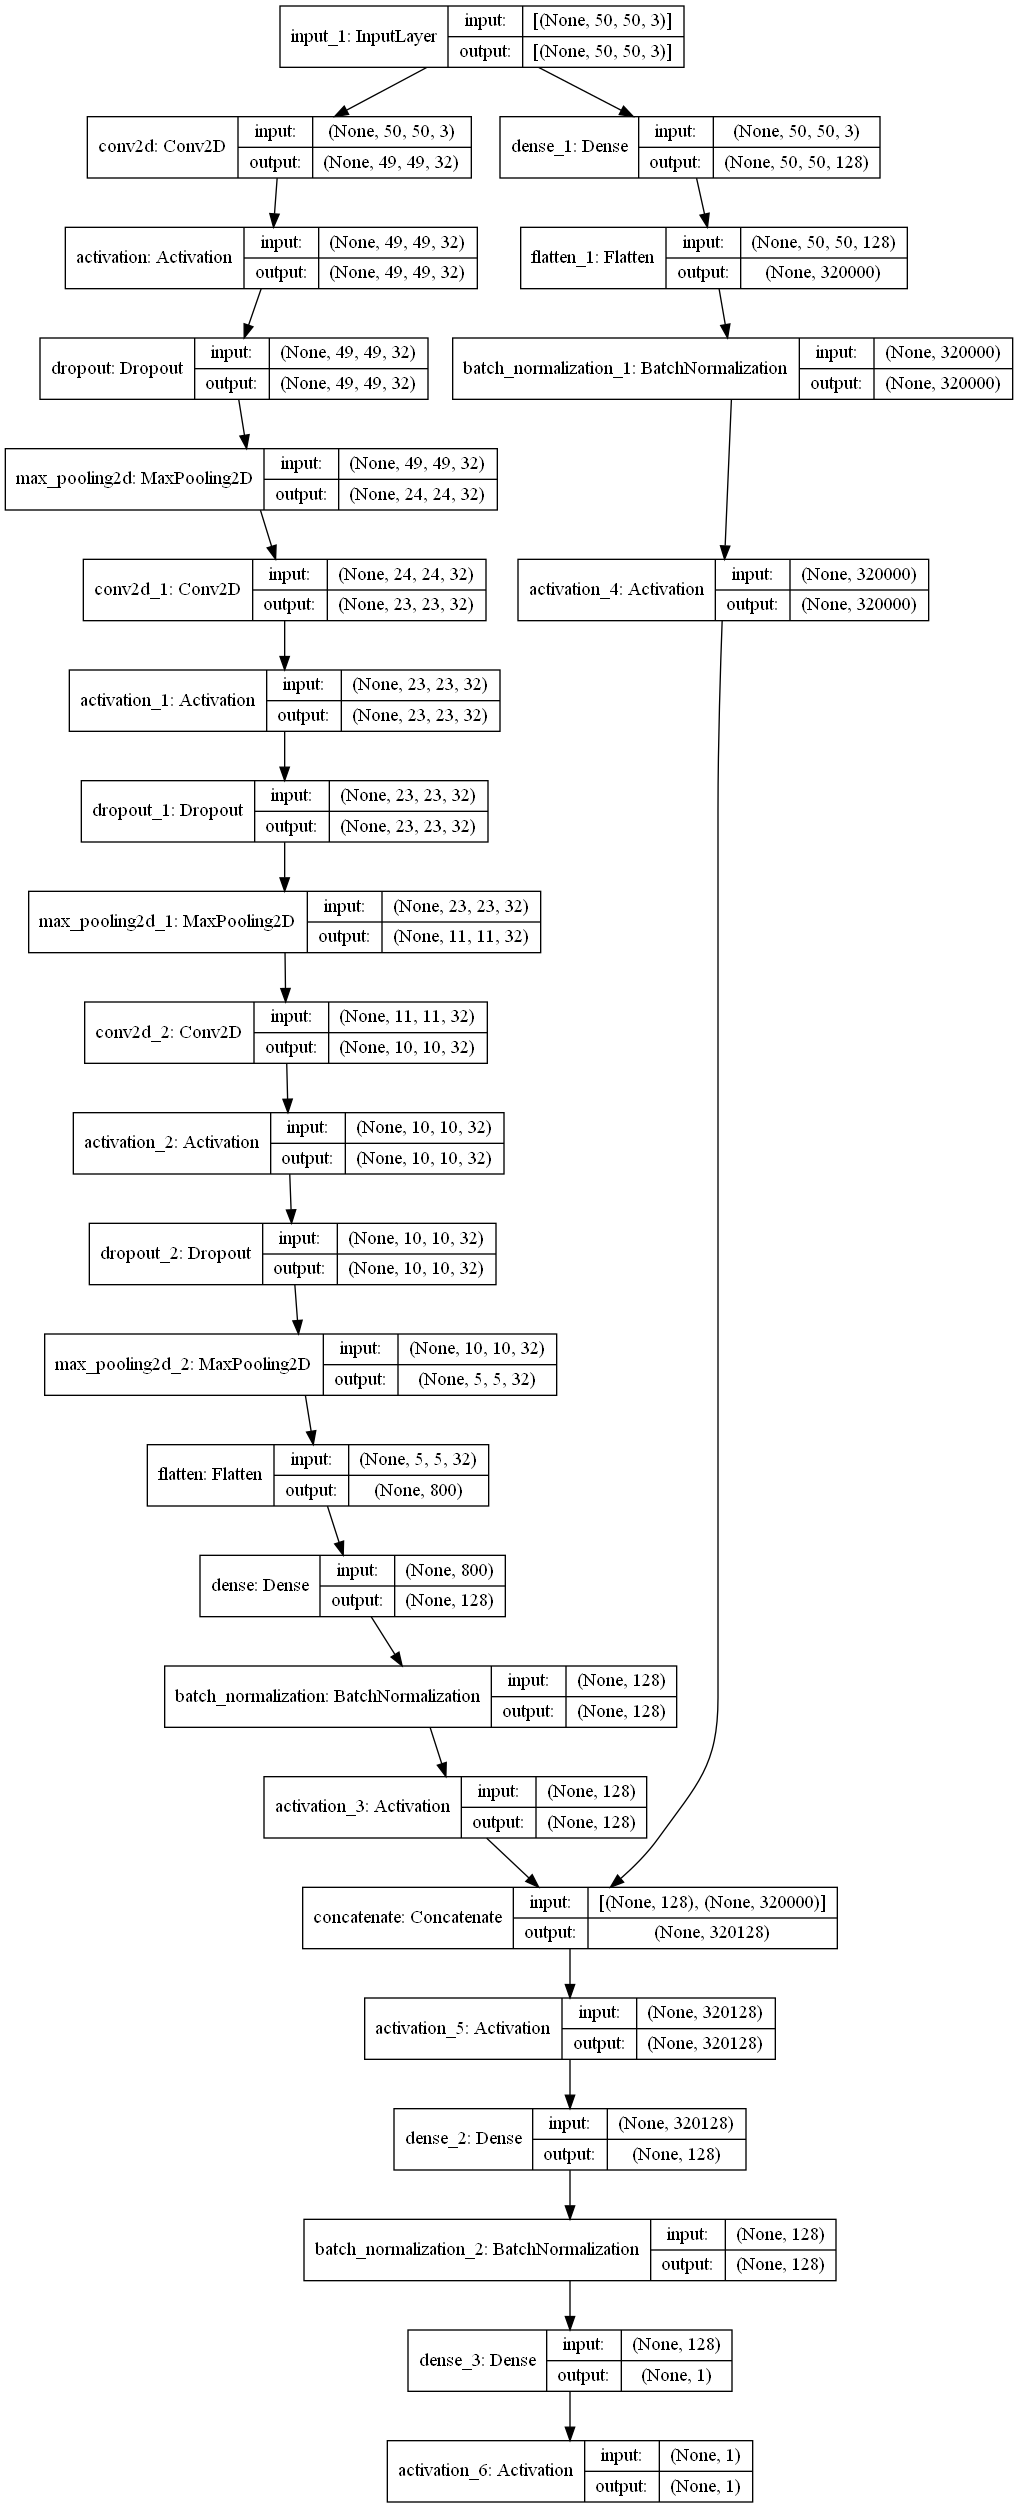

In [5]:
plot_model(model,show_shapes=True,show_layer_names=True)

In [29]:
# model = Sequential()

# model.add(Input(shape=(50,50,3)))
# model.add(Conv2D(32,(2,2),activation='relu',name='conv_2d_1'))

# model.add(Dropout(0.8))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(32,(2,2),activation='relu'))

# model.add(Dropout(0.8))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Flatten())
# model.add(Dense(128))
# model.add(BatchNormalization())
# model.add(Activation(activation='relu'))

# model.add(Dense(128))
# model.add(Dense(1,activation='sigmoid'))

# adam = Adam(learning_rate=1e-4)
# model.compile(optimizer=adam,
#             loss='binary_crossentropy',
#             metrics=['accuracy'])

# model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_2d_1 (Conv2D)           (None, 49, 49, 32)        416       
_________________________________________________________________
dropout_6 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 23, 23, 32)        4128      
_________________________________________________________________
dropout_7 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3872)             

In [27]:
# from keras.utils import plot_model

# plot_model(model, show_dtype=True, show_layer_names=True, show_shapes=True)

In [34]:
# model_ve = Sequential()

# model_ve.add(Input(shape=(120,120,3)))
# model_ve.add(Dense(128))
# model_ve.add(BatchNormalization())
# model_ve.add(Activation(activation='relu'))

# model_ve.summary()

In [35]:
# model = Model()

In [36]:
# model = Sequential()
# # Adding a densely-connected layer with 64 units to the model
# model.add(Conv2D(32, (2,2), activation='relu',input_shape=(120,120,3)))
# # model.add(MaxPooling2D(pool_size = (2,2)))
# # model.add(Dropout(0.25))
# # Add another
# model.add(Conv2D(64, (3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# # model.add(Dropout(0.25))
# # Add another
# model.add(Conv2D(64, (3,3), activation='relu',kernel_regularizer='l2'))
# # model.add(MaxPooling2D(pool_size=(2,2)))
# # model.add(Dropout(0.25))

# model.add(Conv2D(64, (3,3), activation='relu',kernel_regularizer='l2'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Flatten())
# model.add(Dense(128,activation='relu'))
# model.add(Dense(128,activation='relu'))

# model.add(Dense(1, activation='sigmoid'))

# adam = Adam(learning_rate=1e-2)

# model.compile(optimizer=adam,
#                 loss='binary_crossentropy',
#                 metrics=['accuracy'])
# model.summary()

In [19]:
# STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
# STEP_SIZE_VALIDATE = valid_generator.n//valid_generator.batch_size
history = model.fit_generator(generator=train_generator,validation_data=valid_generator,epochs=10)

C:\Users\fharookshaik\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Epoch 1/10
 405/1762 [=====>........................] - ETA: 8:10 - loss: 1.8370 - accuracy: 0.5337C:\Users\fharookshaik\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
1762/1762 [==============================] - 583s 324ms/step - loss: 1.0951 - accuracy: 0.5345 - val_loss: 0.6948 - val_accuracy: 0.5421
Epoch 2/10
1762/1762 [==============================] - 301s 171ms/step - loss: 0.6910 - accuracy: 0.5466 - val_loss: 0.7135 - val_accuracy: 0.5207
Epoch 3/10
1762/1762 [==============================] - 329s 186ms/step - 

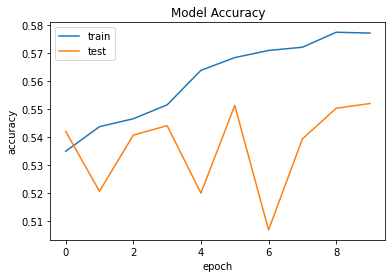

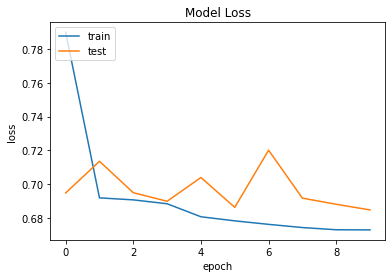

In [21]:
# Model Outputs

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()